## Setup

In [ ]:
!apt-get update && apt-get install swig cmake
!pip install box2d-py
!pip install "stable-baselines3[extra]>=2.0.0a4"

In [ ]:
import torch
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import warnings

# warnings.filterwarnings("ignore", category=UserWarning)
import gymnasium as gym
from gymnasium.spaces import *
import numpy as np
import copy

# import matplotlib.pyplot as plt

max_floor = 5
max_capacity = 10
time_per_floor = 0.0167
time_per_person = 0.033
stationary_cost = 0.5

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


## Passenger Generation

In [ ]:
class Passenger(object):
    def __init__(self, floor, destination, laichzeit):
        self.floor = floor
        self.destination = destination
        self.laichzeit = laichzeit
        self.intent = self.floor > self.destination  # 1 for down 0 for up
        self.entry_time = laichzeit
        # self.in_elevator = False

    def __str__(self) -> str:
        return f"this passgner is spawned at {self.laichzeit} at floor {self.floor} trying to reach {self.destination}"

### Generator

In [ ]:
class Rider_Generator():
    def __init__(self, max_floor) -> None:
        self.waiting_list = {}
        self.total_passenger_count = 0

    def prepare(
        self,
        sigma=60,
        sigma2=90,
        morning_peak_time=480,
        lunch_volume=5 * max_capacity,
        morning_evening_volume=10 * max_capacity,
        lunch_peak_time_up=810,
        evening_peak_time=1020,
        lunch_peak_time_down=690
    ):
        X1 = np.random.normal(morning_peak_time, sigma, morning_evening_volume)
        X2 = np.random.normal(lunch_peak_time_up, sigma2, lunch_volume)
        X_up = np.concatenate([X1, X2])

        X3 = np.random.normal(lunch_peak_time_down, sigma2, lunch_volume)
        X4 = np.random.normal(evening_peak_time, sigma, morning_evening_volume)
        X_down = np.concatenate([X3, X4])
        return X_up, X_down

    def spawn(self, X_up, X_down):
        rng = np.random.default_rng()
        up_floors_calls = rng.exponential(scale=5, size=X_up.shape[0]) - 1
        up_floors_calls = np.round(up_floors_calls)  # + 1
        up_floors_calls = np.clip(up_floors_calls, a_min=0, a_max=max_floor - 2)
        up_floors_destinations = rng.uniform(
            up_floors_calls, max_floor - 1, X_up.shape[0]
        )
        up_floors_destinations = np.clip(
            np.round(up_floors_destinations), a_min=0, a_max=max_floor - 1
        )

        down_floors_calls = rng.exponential(scale=5, size=X_down.shape[0])
        down_floors_calls = max_floor - np.round(down_floors_calls)
        down_floors_calls = np.clip(down_floors_calls, a_min=1, a_max=max_floor - 1)
        down_floors_destinations = rng.uniform(0, down_floors_calls, X_up.shape[0])
        down_floors_destinations = np.clip(
            np.round(down_floors_destinations), a_min=0, a_max=max_floor - 1
        )

        up_floors_calls = up_floors_calls[np.argsort(X_up)]
        down_floors_calls = down_floors_calls[np.argsort(X_down)]
        spawn_locations = np.concatenate((up_floors_calls, down_floors_calls))
        up_floors_destinations = up_floors_destinations[np.argsort(X_up)]
        down_floors_destinations = down_floors_destinations[np.argsort(X_down)]
        destinations = np.concatenate(
            (up_floors_destinations, down_floors_destinations)
        )

        spawn_times = np.concatenate((np.sort(X_up), np.sort(X_down)))
        return spawn_times, spawn_locations, destinations

    def assign_passengers(
        self,
        sigma=60,
        sigma2=90,
        morning_peak_time=480,
        lunch_volume=5 * max_capacity,
        morning_evening_volume=10 * max_capacity,
        lunch_peak_time_up=810,
        evening_peak_time=1020,
        lunch_peak_time_down=690
    ):
        if self.total_passenger_count != 0:
            return self.total_passenger_count, copy.deepcopy(self.waiting_list)
        for j in range(max_floor):
            self.waiting_list[j] = []
        X_up, X_down = self.prepare(
            sigma,
            sigma2,
            morning_peak_time,
            lunch_volume,
            morning_evening_volume,
            lunch_peak_time_up,
            evening_peak_time,
            lunch_peak_time_down,
        )
        spawn_times, spawn_locations, destinations = self.spawn(X_up, X_down)

        for i in range(len(spawn_locations)):
            idx = int(spawn_locations[i])
            passenger = Passenger(spawn_locations[i], destinations[i], spawn_times[i])
            self.waiting_list[idx].append(passenger)
        self.total_passenger_count = spawn_times.shape[0]
        return self.total_passenger_count, copy.deepcopy(self.waiting_list)

## Sample Passenger Generation

In [ ]:
def plotting_peaks(Ups, Downs):
  fig, axes = plt.subplots(nrows=1, ncols=2)

  # Plot on the first subplot (left)
  axes[0].hist(Downs, 30, density=False)
  axes[0].set_xlabel('#th minute')
  axes[0].set_ylabel('# of Passengers')
  axes[0].set_title('Down Calls')

  # Plot on the second subplot (right)
  axes[1].hist(Ups, 30, density=False)
  axes[1].set_xlabel('#th minute')
  axes[1].set_ylabel('# of Passengers')
  axes[1].set_title('Up Calls')

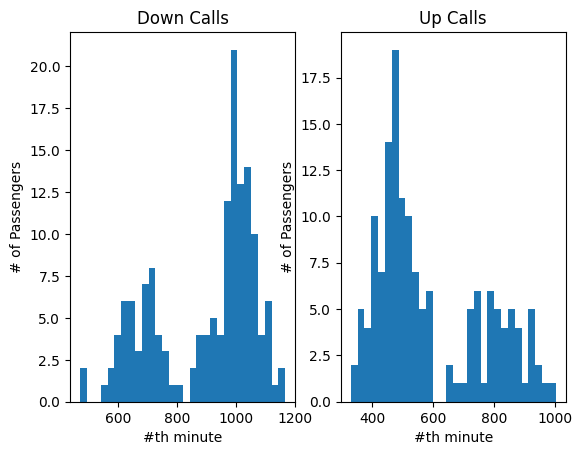

In [ ]:
generator1 = Rider_Generator(max_floor)
going_up, going_down = generator1.prepare()
plotting_peaks(going_up, going_down)

## Environment

In [ ]:
class Environemnt(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super(Environemnt, self).__init__()
        self.total_waiting_time = 0
        self.curr_capacity = 0
        self.curr_floor = 0
        self.timer = 450
        self.step_limit = 8192
        self.generator = Rider_Generator(max_floor)
        self.total_passenger_count, self.waiting_list = self.generator.assign_passengers()
        self.in_elevator_list = {}
        for j in range(max_floor):
            self.in_elevator_list[j] = []
        self.action_space = Discrete(3, start=0)
        self.observation_space = MultiDiscrete(
            ([self.total_passenger_count] * (-2 + max_floor * 2))
            + [max_capacity + 1, max_capacity + 1, max_floor]
        )

    def load_passengers(self):
        reward = 0
        passengers_list = self.waiting_list[self.curr_floor]
        loaded = []
        for idx in range(len(passengers_list)):
            if self.curr_capacity >= max_capacity:
                break
            else:
                p = passengers_list[idx]
                if self.timer > p.laichzeit:
                    self.timer += time_per_person
                    self.curr_capacity += 1
                    self.in_elevator_list[p.destination].append(p)
                    loaded.append(idx)
                    reward += 50
                    if self.timer - p.laichzeit > 1:
                        reward -= int(self.timer - p.laichzeit)

        loaded = sorted(loaded, reverse=True)
        for l in loaded:
            self.waiting_list[self.curr_floor].pop(l)
        return reward

    def offload_passengers(self):
        off_board = self.in_elevator_list[self.curr_floor]
        reward = len(off_board)
        self.curr_capacity -= reward
        for i in off_board:
            self.timer += time_per_floor
        self.in_elevator_list[self.curr_floor] = []
        return reward * 50

    # More work here
    def step(self, action):
        reward = -5
        if action == 0:
            self.timer += stationary_cost
            self.total_waiting_time += self.offload_passengers()
            reward += self.load_passengers()

        if action == 1:
            if self.curr_floor == max_floor - 1:
                reward -= 50
                self.timer += stationary_cost
            else:
                self.timer += time_per_floor
                self.curr_floor += 1

        if action == 2:
            if self.curr_floor == 0:
                reward -= 50
                self.timer += stationary_cost
            else:
                self.timer += time_per_floor
                self.curr_floor -= 1

        truncated = False
        self.step_limit -= 1
        info, terminated, observation = self.get_state()
        # if terminated:
        #     reward += 10000
        if self.step_limit == 0:
            truncated = True
            terminated = True
            # reward -= 10000
        return observation, float(reward), terminated, truncated, info

    # calculated penalty here
    # get destination for inelevator people
    def get_state(self):
        passenger_count = 0
        reward = 0
        global_state = np.zeros(len(self.waiting_list.keys()) * 2 + 1, dtype=int)
        for i in self.waiting_list.keys():
            for passenger in self.waiting_list[i]:
                if passenger.laichzeit < self.timer:
                    global_state[2 * i - passenger.intent] += 1
            passenger_count += len(self.waiting_list[i])
        ups, downs = 0, 0
        for j in self.in_elevator_list.keys():
            for p in self.in_elevator_list[j]:
                if p.destination < self.curr_floor:
                    downs += 1
                else:
                    ups += 1

        global_state[-3] = ups
        global_state[-2] = downs
        global_state[-1] = self.curr_floor

        info = {"Cumulative travel time": self.total_waiting_time}
        is_done = passenger_count == 0 and self.curr_capacity == 0
        return info, is_done, global_state

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.curr_capacity = 0
        self.curr_floor = 0
        self.timer = 450
        self.total_waiting_time = 0

        for j in self.in_elevator_list.keys():
            self.in_elevator_list[j] = []
        (
            self.total_passenger_count,
            self.waiting_list,
        ) = self.generator.assign_passengers()
        self.step_limit = 8192
        info, _, obs = self.get_state()
        return obs, info

    def render(self, mode="human", close=False):
        """
        Copied from
        https://github.com/saykim/elevator-reinforcementlearning-application/blob/master/environment/Building.py
        """
        for idx in reversed(list(range(1,self.max_floor))):
            print("=======================================================")
            print("= Floor #%02d ="%idx, end=' ')
            for e in self.elevators:
                if e.curr_floor == idx:
                    print("  Lift #%d"%e.idx, end=' ')
                else:
                    print("         ", end=' ')
            print(" ")
            print("=  Waiting  =", end=' ')
            for e in self.elevators:
                if e.curr_floor == idx:
                    print("    %02d   "%len(e.curr_passengers_in_elv), end=' ')
                else:
                    print("          ", end=' ')
            print(" ")
            print("=    %03d    ="%len(self.floors_information[idx]))
        print("=======================================================")
        print("= Floor #00 =", end=' ')
        for e in self.elevators:
            if e.curr_floor == 0:
                print("  Lift #%d"%e.idx, end=' ')
            else:
                print("         ", end=' ')
        print(" ")
        print("=  Arrived  =", end=' ')
        for e in self.elevators:
            if e.curr_floor == 0:
                print("    %02d   "%len(e.curr_passengers_in_elv), end=' ')
            else:
                print("          ", end=' ')
        print(" ")
        print("=    %03d    ="%len(self.floors_information[0]))
        print("=======================================================")
        print("")
        print("People to move: %d "%(self.remain_passengers_num - len(self.floors_information[0])))
        print("Total # of people: %d"%self.remain_passengers_num)
        print('state : ',self.get_state())

### Environemnt Check

In [ ]:
log_dir = "/content/elevator/"
os.makedirs(log_dir, exist_ok=True)

building = Environemnt()
env_checker.check_env(building, True, True)
building = Monitor(building, log_dir)

## Training

### Call back for saving the best model in terms of reward

In [ ]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

### Start Training

In [ ]:
from stable_baselines3.common.logger import configure

building.reset()

policy_kwargs = dict(
    activation_fn=torch.nn.ReLU,
    net_arch=dict(pi=[64, 32], vf=[64, 32]),
    share_features_extractor=False,
)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir, verbose=0)
logger = configure(log_dir, ["json", "csv"])

model = PPO(
    "MlpPolicy",
    building,
    clip_range=0.2,
    clip_range_vf=0.05,
    gae_lambda=0.7,
    policy_kwargs=policy_kwargs,
    verbose=1
)
model.set_logger(logger)
model.learn(total_timesteps=40960, callback=callback)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using cpu device
Wrapping the env in a DummyVecEnv.


## Visualization

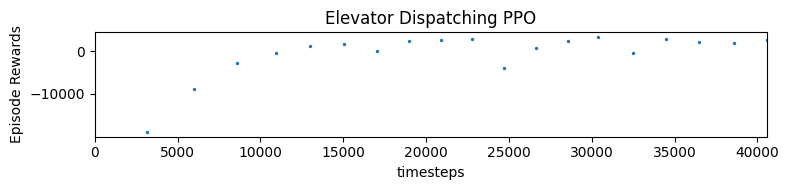

In [ ]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "Elevator Dispatching PPO"
)